## The Planet Challenge: Understanding the Amazon from Space

This workbook demonstrates the use of Pytorch and Residual Networks for applying labels to images taken by satellites. 

The project is divided into four parts:

 1. Importing and Handling Data
 2. Training the Network
 3. Validating and inspecting results
 4. Generating predictions on test data.
 
If you don't want to spend all the time it takes to train the network yourself, you can just load the pretrained model. Just make sure the model has been downloaded from github LFS and run the cell labelled _Loading the Pretrained Model_.

## 0. Setup
You'll need to load the dependencies and set up torch here. 

In [165]:
# Imaging stuff
from PIL import Image
from IPython.display import display

# Math Stuff
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd

# Useful stuff
import os
import copy
import time

# DL Stuff
import torch 
from torch import nn, optim
from torchvision import transforms, utils
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader


In [166]:
# Tell pytorch to run matrix calculations on the GPU
device = torch.device("cuda:0")

## 1. Importing and Handling Data
This includes loading the data, formatting it for training and defining some utility functions.

In [167]:
# load the training dataset
labels = pd.read_csv("train_v2.csv")
labels.shape

(40479, 2)

In [168]:
labels.set_index('image_name', inplace=True)

In [169]:
# Run this to view a random image.
index = random.randint(0, labels.shape[0])
print(labels.iloc[index])

tags    agriculture clear cultivation primary road
Name: train_37317, dtype: object


In [170]:
# Inspect some of the training data labels.
labels.iloc[:5]

,tags
image_name,
train_0,haze primary
train_1,agriculture clear primary water
train_2,clear primary
train_3,clear primary
train_4,agriculture clear habitation primary road


In [171]:
# Here you can reduce the size of the Dataset (for faster training while prototyping)
size_limit = None
if size_limit:
    labels = labels.iloc[:size_limit]

In [172]:
# Get one-hot encoding for all samples.
def one_hot_encode(tags):
    possible_labels = ["agriculture", "artisinal_mine", "bare_ground", "blooming", "blow_down", "clear", "cloudy", "conventional_mine", "cultivation", "habitation", "haze", "partly_cloudy", "primary", "road", "selective_logging", "slash_burn", "water"]
    output = [(1.0 if label in tags.split(" ") else 0.0) for label in possible_labels]
    return output

# Turn the one hot encoding (or positive/negative encoding) back into a string of labels.
def onehot_decode(prediction):
    possible_labels = ["agriculture", "artisinal_mine", "bare_ground", "blooming", "blow_down", "clear", "cloudy", "conventional_mine", "cultivation", "habitation", "haze", "partly_cloudy", "primary", "road", "selective_logging", "slash_burn", "water"]
    onehot = [True if i > 0 else False for i in prediction]
    prediction_string = ""
    for i in range(len(onehot)):
        if onehot[i]:
            prediction_string += (" " + possible_labels[i])
            
    return prediction_string[1:]

labels['one_hot'] = list(map(one_hot_encode, labels['tags']))

In [173]:
# Inspect some of the one-hot encodings.
labels[:5]

,tags,one_hot
image_name,,
train_0,haze primary,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
train_1,agriculture clear primary water,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
train_2,clear primary,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
train_3,clear primary,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
train_4,agriculture clear habitation primary road,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


In [174]:
# Keep 80% for training
mask = np.random.randn(labels.shape[0]) < 0.8
train = labels.iloc[mask]

# The other 20% is used for validation
validation = labels.iloc[~mask]

In [86]:
train_transformer = transforms.Compose([
    transforms.Resize(224),              # resize the image to 64x64 
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()])             # transform it into a PyTorch Tensor

eval_transformer = transforms.Compose([
    transforms.Resize(224),              # resize the image to 64x64 
    transforms.ToTensor()])             # transform it into a PyTorch Tensor

In [87]:
# This stuff comes from here: https://cs230-stanford.github.io/pytorch-vision.html
# Making a basic class to represent the properties of our training dataset.

class PlanetDataset(Dataset):
    
    # Each dataset is a list of filenames with their corresponding one-hot encodings
    # calling an image returns a randomly transformed version of the image itself.
    
  def __init__(self, directory, input_df, transform):      
    # store filenames
    self.filenames = input_df.index.values
    self.filenames = [(os.path.join(directory, f) + ".jpg") for f in self.filenames]
      
    # the first character of the filename contains the label
    self.labels = list(input_df['one_hot'])
    self.transform = transform
      
  def __len__(self):
    # return size of dataset
    return len(self.filenames)
      
  def __getitem__(self, idx):
    # open image, apply transforms and return with label
    image = Image.open(self.filenames[idx])  # PIL image
    image = self.transform(image)[:3]
    return image, torch.FloatTensor(self.labels[idx])

In [88]:
train_dataset = PlanetDataset('train-jpg', input_df=train, transform=train_transformer)
val_dataset = PlanetDataset('train-jpg', input_df=validation, transform=eval_transformer)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

agriculture clear primary road


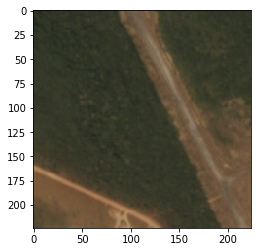

In [161]:
# Inspect an image

# Run this cell as many times as you want to see a random image and its labels.

def show(img):
    # This function will show an image from our dataset. 
    npimg = 1 - img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

image, image_labels = train_dataset[random.randint(0,len(train_dataset))]
print(onehot_decode(image_labels.numpy()))
show(image)

In [116]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()
    dataset_sizes = {'train':len(train_dataloader)*32, 'val':len(val_dataloader)*32}
    
    loss_logs = {'train':[], 'val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            
            loss_logs[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model, loss_logs

## Defining the Model:

We will use a ResNet34 Architecture ([Learn more here!](https://arxiv.org/pdf/1512.03385.pdf)) for labelling satellite images.Pytorch offers a pre-trained model which we can easily customize by re-training the last layer and adding a 17-bit binary output to correspond to the 17 possible labels we are trying to assign.

In [118]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 17)
    
criterion = nn.BCEWithLogitsLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

model = model.cuda()

In [195]:
# Train the model! (This takes a long time!)
model, logs = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, num_epochs=20)

Epoch 0/19
----------


Process Process-5:
Process Process-6:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeou

KeyboardInterrupt: 

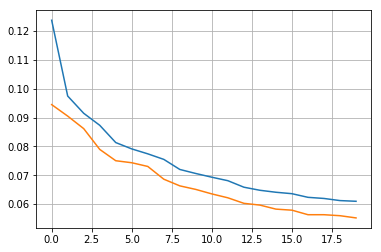

In [71]:
plt.plot(logs['train'])
plt.plot(logs['val'])
plt.grid(True)

In [128]:
torch.save(model.state_dict(), "resnet_34_planet_challenge_20_epochs.pt")

## 3. Validating the model and inspecting results
Here we'll manually inspect a few predictions and see how the model is performing.

### (Import the pre-trained model here!)
This model was trained over 30 Epochs with CUDA on an NVIDIA P4000 8GB GPU. It took almost two hours to train.

In [193]:
# You can also load the pretrained model here and just run the evaluations:
# ONLY RUN THIS IF YOU WANT TO USE THE PRE-TRAINED MODEL, OTHERWISE IT WILL OVERWRITE YOUR TRAINED MODEL!
model.load_state_dict(torch.load("resnet_34_planet_challenge_30_epochs.pt"));
model.eval();

Correct labels:  clear primary
predicted labels:  clear primary


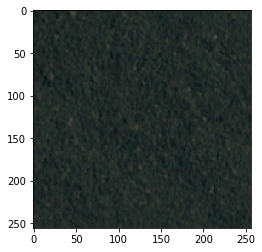

In [194]:
# Analyze some predictions
# This will load a random image from the training set and use the model to predict its labels.
idx = random.randint(0, 40000)
row = labels.iloc[idx]
tags = row.one_hot
image = Image.open('train-jpg/train_' + str(idx) + '.jpg')  # PIL image
imshow(image)
image = eval_transformer(image)[:3].unsqueeze(0).cuda()
prediction = model(image)[0].cpu().detach().numpy()

print("Correct labels: ", onehot_decode(tags))
print("predicted labels: ", onehot_decode(prediction))

In [156]:
# Get the model's predictions on the entire validation dataset:
np_outputs = []
np_labels = []

for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        np_outputs.extend(outputs.cpu().numpy())
        np_labels.extend(labels.cpu().numpy())
        
np_outputs = np.array(np_outputs)
np_labels = np.array(np_labels)

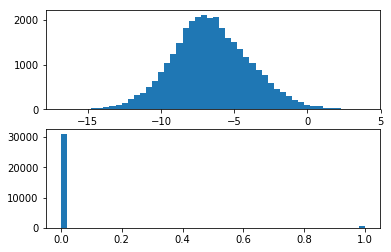

In [157]:
# Generate Histogram of a given column
column = 2
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

ax1.hist(np_outputs[:, column], bins=50);
ax2.hist(np_labels[:, column], bins=50);

## 4. Making predictions on test output:

Here we'll iterate through the entire test set and make a list of (filename, outputs) tuples.
Afterwards we'll decode the one-hot encodings and write to a .csv as specified by the kaggle competition. 

Kaggle wants a .csv file where each line is a filename and a string of space-separaated labels.

In [187]:
# Get the names of all of the files:
test_filenames = os.listdir("test-jpg")

In [188]:
final_predictions = []

for i in range(len(test_filenames)):
    image = Image.open('test-jpg/' + test_filenames[i])  # PIL image
    image = eval_transformer(image)[:3].unsqueeze(0).cuda()
    output = model(image).cpu().detach().numpy()[0]
    final_predictions.append([test_filenames[i][:-4], onehot_decode(output)])

In [191]:
final_predictions[:10]

[['test_25202', 'agriculture partly_cloudy primary'],
 ['test_5717', 'clear cultivation habitation primary'],
 ['test_40598', 'agriculture clear primary'],
 ['file_2096', 'clear primary water'],
 ['file_19729', 'partly_cloudy primary'],
 ['file_423', 'agriculture cultivation primary'],
 ['file_401', 'clear primary road water'],
 ['test_35442', 'clear primary water'],
 ['file_7286', 'clear primary'],
 ['test_22859', 'haze primary']]

In [134]:
# write predictions to file:
import csv

with open('predictions.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['image_name', 'tags'])
    for item in final_predictions:
        writer.writerow([item[0], item[1]])